In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.read_csv('/Users/aaronbroderick/Desktop/Data Science Folders/Data/FineFoods.csv')

In [4]:
w = list(df.ProductId.value_counts().index)

In [5]:
title = w[50]
product = df[df['ProductId'] == title]

In [6]:
product = df[df['ProductId'] == title]
product = product.reset_index(drop = True)
product = pd.DataFrame(product)

In [7]:
product.shape

(455, 10)

## Find the expertise of each reviewer

In [8]:
# Names of reviewers for this product
reviewers = list(product.ProfileName)

# All the reviews in the dataset
x = list(df.ProfileName)

results = []
for i in range(len(reviewers)):
    
    # Count the total reviews of each reviewer in the data set
    review_count = x.count(reviewers[i])
    
    results.append(review_count)

product['expertise'] = results

## Find the lag 

In [9]:
import datetime

def make_dates(integer):
    x = datetime.datetime.fromtimestamp(integer)
    x = str(x)
    x = x.split()
    x = x[0]
    return x

product['datetime'] = product.Time.apply(make_dates)
product['datetime'] = product.datetime.apply(pd.to_datetime) 
product.datetime = product.datetime.apply(pd.to_datetime)

In [10]:
product['lag'] = 0
results = []
for j in range(len(product)):
    y = product.datetime.iloc[j] - product.datetime.min()
    results.append(y.days)
    
product.lag = results

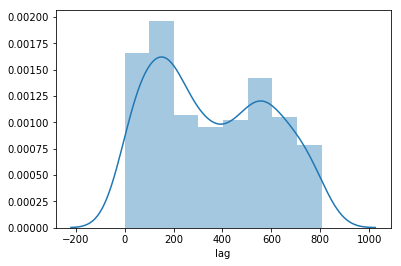

In [11]:
sns.distplot(product.lag)

## Make Lag Buckets

In [12]:
bucket = max(product.lag)//10
bucket

80

In [13]:
def make_buckets(numb):
    return (numb//bucket * bucket) + 80

product['lag_buckets'] = product.lag.apply(make_buckets)

## Make a Parser with spaCy

In [16]:
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

# We want to use the standard english-language parser.
parser = spacy.load('en')

## Clean and Summarize Text

In [17]:
product.Text[20]

'As a French Roast fan, I bought this brand of K-cup with high expectations, considering the name attached to it. I was disappointed. It has a hearty aroma and full-bodied flavor but leaves a bitter aftertaste.<br /><br />If you\'re a lover of the more robust roasts, I would recommend trying the <a href="http://www.amazon.com/gp/product/B002L41Y8A">Coffee People Kona Blend Island Style, Extra Bold K-Cups for Keurig Brewers (Pack of 50)</a> instead. It is a smooth blend with none of the bitterness that delivers that kick you\'re likely looking for.'

In [18]:
import re
def summarize(text):
    #text = text.replace("<br />", ".")
    text = re.sub(r'<.+?>', '', text)
    text = text.replace('.','. ')
    # Parsing
    text = parser(text)

    # Dividing the text into sentences and storing them as a list of strings.
    sentences=[]
    for span in text.sents:
        # go from the start to the end of each span, returning each token in the sentence
        # combine each token using join()
        sent = ''.join(text[i].string for i in range(span.start, span.end)).strip()
        sentences.append(sent)
    if len(sentences) == 1:
        return text
    else:
        # Creating the tf-idf matrix.
        counter = TfidfVectorizer(lowercase=False, 
                                  stop_words=None,
                                  ngram_range=(1, 1), 
                                  analyzer=u'word', 
                                  max_df=.5, 
                                  min_df=1,
                                  max_features=None, 
                                  vocabulary=None, 
                                  binary=False)
        #Applying the vectorizer
        data_counts=counter.fit_transform(sentences)
        # Calculating similarity
        similarity = data_counts * data_counts.T
        # Identifying the sentence with the highest rank.
        nx_graph = nx.from_scipy_sparse_matrix(similarity)
        ranks=nx.pagerank(nx_graph, alpha=.85, tol=.000001)
        ranked = sorted(((ranks[i],s) for i,s in enumerate(sentences)),
                        reverse=True)
        return ranked[0][1]

In [19]:
product['summary'] = product.Text.apply(summarize)

In [20]:
final = product[['Score','HelpfulnessNumerator','expertise','lag_buckets','summary']]

In [21]:
final.head(10)

,Score,HelpfulnessNumerator,expertise,lag_buckets,summary
0,5,1,9,320,"While there are many choices, I prefer a bold,..."
1,5,1,10,240,We were pleasantly surprised that this had a g...
2,4,1,10,240,Wish it was available in whole bean as I like ...
3,5,1,9,240,". I would recommend it after dinner, but not ..."
4,3,1,40,240,This is the most USEFUL info you will ever nee...
5,2,1,9,240,Stick with normal pods or extra bold if you li...
6,2,1,28,240,I'm really disappointed because I now have a b...
7,5,1,9,240,"She does not like bold coffee flavors, but is ..."
8,1,1,81,240,"This is a good decaf coffee, but I've never be..."
9,2,1,9,240,Warning: this is a STRONG flavor.


In [58]:
final.to_csv('review_animation')